# ERS Rurality codes

Prepare dataframes with [ERS rurality codes](https://www.ers.usda.gov/topics/rural-economy-population/rural-classifications/).

The main interface functions of the module are `get_ruc_df`, `get_ui_df` and `get_ruca_df`. Importing module and calling one of these functions will return pandas DataFrame, downloading and constructing data if it does not exist.

Construction of each dataframe takes the following steps.
- Download Excel spreadsheets with code data and documentation.
- Normalize column names.
- Stack all years into a single dataframe and save it as CSV file.
- Combine pieces of documentation and column renaming schemes into a text file. Text is tab-separated and can be loaded in tabular format.

UI stats: @fig-ui-stats.

In [2]:
import pandas as pd

from rurec.util import download_file
from rurec.reseng.config import Paths
from rurec import geography

PATH = Paths(
    ruc='data/ers_codes/ruc.csv',
    ruc_doc='data/ers_codes/ruc_doc.txt',
    ui='data/ers_codes/ui.csv',
    ui_doc='data/ers_codes/ui_doc.txt',
    ruca='data/ers_codes/ruca.csv',
    ruca_doc='data/ers_codes/ruca_doc.txt'
)

Module "rurec.reseng.config" read config from "/Users/anton/work/rurec/submodules/reseng/settings.ini".


In [3]:
#hide
import matplotlib as mpl
import matplotlib.pyplot as plt
import folium

# Rural-Urban Continuum

[Homepage](https://www.ers.usda.gov/data-products/rural-urban-continuum-codes/)

In [ ]:
def get_ruc_df():
    """Return `pandas.DataFrame` of Rural-Urban Continuum codes for all years."""
    if not PATH.ruc.exists():
        print(f'RUC data not found at "{PATH.ruc}", attempting to download and construct...')
        download_and_combine_ruc()
    df = pd.read_csv(PATH.ruc, dtype='str')
    for c in ['RUC_YEAR', 'POPULATION_YEAR', 'POPULATION', 'PERCENT_NONMETRO_COMMUTERS']:
        df[c] = pd.to_numeric(df[c])
    cats = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    df['RUC_CODE'] = pd.Categorical(df['RUC_CODE'], cats, True)
    return df

def download_and_combine_ruc():
    """Download Rural-Urban Continuum codes and documentation.
    Combine all years of data into single CSV file.
    Save all documentation into single TXT file.
    """
    PATH.ruc.parent.mkdir(parents=True, exist_ok=True)
    ruc_orig = PATH.ruc.parent/'ruc_orig'
    ruc_dfs = []
    ruc_doc_dfs = []

    # 1974
    url = 'https://www.ers.usda.gov/webdocs/DataFiles/53251/ruralurbancodes1974.xls?v=9631.3'
    fname = download_file(url, ruc_orig)
    df = pd.read_excel(fname, dtype='str', nrows=3141)
    cols_map = {'FIPS Code': 'FIPS', 'State': 'STATE', 'County Name': 'COUNTY', '1974 Rural-urban Continuum Code': 'RUC_CODE'}
    df = df.rename(columns=cols_map)
    df['RUC_YEAR'] = '1974'
    ruc_dfs.append(df)

    df = pd.concat([
        pd.DataFrame(['RUC 1974 documentation', '-' * 80, f'Data source: {url}']),
        pd.DataFrame([[''], ['Column names'], ['Renamed', 'Original']]),
        pd.DataFrame([[v, k] for k, v in cols_map.items()]),
        pd.DataFrame(['']),
        pd.read_excel(fname, dtype='str', skiprows=3143, header=None).dropna(1, 'all')])
    ruc_doc_dfs.append(df)


    # 1983
    # 1993 file is contained within 1983-1993 file. 2003 file repeats 1993 column.
    url = 'https://www.ers.usda.gov/webdocs/DataFiles/53251/cd8393.xls?v=9631.3'
    fname = download_file(url, ruc_orig)

    df = pd.read_excel(fname, dtype='str')
    cols_map = {'FIPS': 'FIPS', 'State': 'STATE', 'County Name': 'COUNTY', '1983 Rural-urban Continuum Code': 'RUC_CODE'}
    df = df.rename(columns=cols_map)
    df = df[cols_map.values()]
    df['RUC_YEAR'] = '1983'
    ruc_dfs.append(df)

    df = pd.concat([
        pd.DataFrame(['RUC 1983 documentation', '-' * 80, f'Data source: {url}']),
        pd.DataFrame([[''], ['Column names'], ['Renamed', 'Original']]),
        pd.DataFrame([[v, k] for k, v in cols_map.items()])])
    ruc_doc_dfs.extend([pd.DataFrame(['', '']), df])


    # 1993
    df = pd.read_excel(fname, dtype='str')
    cols_map = {'FIPS': 'FIPS', 'State': 'STATE', 'County Name': 'COUNTY', '1993 Rural-urban Continuum Code': 'RUC_CODE'}
    df = df.rename(columns=cols_map)
    df = df[cols_map.values()]
    df['RUC_YEAR'] = '1993'
    ruc_dfs.append(df)

    df = pd.concat([
        pd.DataFrame(['RUC 1993 documentation', '-' * 80, f'Data source: {url}']),
        pd.DataFrame([[''], ['Column names'], ['Renamed', 'Original']]),
        pd.DataFrame([[v, k] for k, v in cols_map.items()])])
    ruc_doc_dfs.extend([pd.DataFrame(['', '']), df])


    # 2003
    url = 'https://www.ers.usda.gov/webdocs/DataFiles/53251/ruralurbancodes2003.xls?v=9631.3'
    fname = download_file(url, ruc_orig)
    df = pd.read_excel(fname, dtype='str')
    cols_map = {'FIPS Code': 'FIPS', 'State': 'STATE', 'County Name': 'COUNTY',
                '2003 Rural-urban Continuum Code': 'RUC_CODE', '2000 Population ': 'POPULATION',
                'Percent of workers in nonmetro counties commuting to central counties of adjacent metro areas': 'PERCENT_NONMETRO_COMMUTERS',
                'Description for 2003 codes': 'RUC_CODE_DESCRIPTION'}
    df = df.rename(columns=cols_map)
    df = df[cols_map.values()]
    df['RUC_YEAR'] = '2003'
    df['POPULATION_YEAR'] = '2000'
    ruc_dfs.append(df)

    df = pd.concat([
        pd.DataFrame(['RUC 2003 documentation', '-' * 80, f'Data source: {url}']),
        pd.DataFrame([[''], ['Column names'], ['Renamed', 'Original']]),
        pd.DataFrame([[v, k] for k, v in cols_map.items()])])
    ruc_doc_dfs.extend([pd.DataFrame(['', '']), df])


    # Puerto Rico 2003
    url = 'https://www.ers.usda.gov/webdocs/DataFiles/53251/pr2003.xls?v=9631.3'
    fname = download_file(url, ruc_orig)
    df = pd.read_excel(fname, dtype='str')

    cols_map = {'FIPS Code': 'FIPS', 'State': 'STATE', 'Municipio Name': 'COUNTY', 'Population 2003 ': 'POPULATION',
                'Rural-urban Continuum Code, 2003': 'RUC_CODE', 'Description of the 2003 Code': 'RUC_CODE_DESCRIPTION'}
    df = df.rename(columns=cols_map)
    df = df[cols_map.values()]
    df['RUC_YEAR'] = '2003'
    df['POPULATION_YEAR'] = '2003'
    ruc_dfs.append(df)

    df = pd.concat([
        pd.DataFrame(['RUC Puerto Rico 2003 documentation', '-' * 80, f'Data source: {url}']),
        pd.DataFrame([['Column names'], ['Renamed', 'Original']]),
        pd.DataFrame([[v, k] for k, v in cols_map.items()])])
    ruc_doc_dfs.extend([pd.DataFrame(['', '']), df])


    # 2013
    url = 'https://www.ers.usda.gov/webdocs/DataFiles/53251/ruralurbancodes2013.xls?v=9631.3'
    fname = download_file(url, ruc_orig)
    df = pd.read_excel(fname, 'Rural-urban Continuum Code 2013', dtype='str')
    cols_map = {'FIPS': 'FIPS', 'State': 'STATE', 'County_Name': 'COUNTY', 'Population_2010': 'POPULATION',
                'RUCC_2013': 'RUC_CODE', 'Description': 'RUC_CODE_DESCRIPTION'}
    df = df.rename(columns=cols_map)
    df = df[cols_map.values()]
    df['RUC_YEAR'] = '2013'
    df['POPULATION_YEAR'] = '2010'
    ruc_dfs.append(df)

    df = pd.concat([pd.DataFrame(['RUC 2013 documentation', '-' * 80, f'Data source: {url}']),
                    pd.DataFrame([[''], ['Column names'], ['Renamed', 'Original']]),
                    pd.DataFrame([[v, k] for k, v in cols_map.items()]),
                    pd.DataFrame(['']),
                    pd.read_excel(fname, 'Documentation', header=None, dtype='str')])
    ruc_doc_dfs.extend([pd.DataFrame(['', '']), df])

    # Combine and save to disk
    df = pd.concat(ruc_dfs)
    df = df[['FIPS', 'STATE', 'COUNTY', 'RUC_YEAR', 'RUC_CODE', 'RUC_CODE_DESCRIPTION', 
             'POPULATION_YEAR', 'POPULATION', 'PERCENT_NONMETRO_COMMUTERS']]
    for col in df:
        df[col] = df[col].str.strip()
    df = df.sort_values(['FIPS', 'RUC_YEAR'])
    df.to_csv(PATH.ruc, index=False)
    print(f'Saved combined data to "{PATH.ruc}".')

    df = pd.concat(ruc_doc_dfs)
    for col in df:
        df[col] = df[col].str.strip()
    df.to_csv(PATH.ruc_doc, '\t', header=False, index=False)
    print(f'Saved documentation to "{PATH.ruc_doc}".')

## Descriptive summary

Documentation notes that not all years are directly comparable.

In 1974, 1983 and 1993 there was code "0", join it with "1" for simplicity.

In [ ]:
#collapse
df = get_ruc_df()
df['RUC_CODE'] = df['RUC_CODE'].replace('0', '1')
df['POPULATION'] = df.groupby('FIPS')['POPULATION'].fillna(method='bfill')

stats = df.groupby(['RUC_YEAR', 'RUC_CODE'])['POPULATION'].agg(['size', 'sum'])
stats['sum'] /= 1000
stats.columns = ['Counties', 'Population']
stats = stats.astype(int).unstack()

# 2003 and 2013 codes are identical
codes = (df.loc[df['RUC_YEAR'] == 2013, ['RUC_CODE', 'RUC_CODE_DESCRIPTION']]
         .dropna().drop_duplicates()
         .sort_values('RUC_CODE')
         .reset_index(drop=True))

pd.options.display.max_colwidth = 200
codes

### Number of counties

In [ ]:
#collapse
data = stats['Counties']
data

In [ ]:
#collapse
fig, ax = plt.subplots(figsize=(6, 4))
idx = [str(x) for x in data.index]
bottom = pd.Series([0] * len(data), index=data.index)
for code in data:
    ax.bar(idx, data[code], bottom=bottom, label=code)
    bottom += data[code]

dummy = mpl.patches.Patch(fill=False, edgecolor='none')
handles, labels = ax.get_legend_handles_labels()
handles = [dummy] + handles[:3] + [dummy] + handles[3:6] + [dummy] + handles[6:]
labels = ['metro'] + labels[:3] + ['nonmetro'] + labels[3:6] + [''] + labels[6:]
ax.legend(handles, labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.1))

ax.set_title('Number of counties by Rural-Urban Continuum code')

plt.show()

### Population

No population in dataset before 2010, so 2010 is used for earlier years.

In [ ]:
#collapse
data = stats['Population']
data

In [ ]:
#collapse
fig, ax = plt.subplots(figsize=(6, 4))
idx = [str(x) for x in data.index]
bottom = pd.Series([0] * len(data), index=data.index)
for code in data:
    ax.bar(idx, data[code], bottom=bottom, label=code)
    bottom += data[code]

dummy = mpl.patches.Patch(fill=False, edgecolor='none')
handles, labels = ax.get_legend_handles_labels()
handles = [dummy] + handles[:3] + [dummy] + handles[3:6] + [dummy] + handles[6:]
labels = ['metro'] + labels[:3] + ['nonmetro'] + labels[3:6] + [''] + labels[6:]
ax.legend(handles, labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.1))

ax.set_title('Population in thousands by Rural-Urban Continuum code')

plt.show()

# Urban Influence {#seq-ui}

[Homepage](https://www.ers.usda.gov/data-products/urban-influence-codes/)
[Documentation](https://www.ers.usda.gov/data-products/urban-influence-codes/documentation/)

> The 2013 Urban Influence Codes form a classification scheme that distinguishes metropolitan counties by population size of their metro area, and nonmetropolitan counties by size of the largest city or town and proximity to metro and micropolitan areas.

In [4]:
def get_ui_df():
    """Return `pandas.DataFrame` of Urban Influence codes for all years."""
    if not PATH.ui.exists():
        print(f'UI data not found at "{PATH.ui}", attempting to download and construct...')
        download_and_combine_ui()
    df = pd.read_csv(PATH.ui, dtype='str')
    for c in ['UI_YEAR', 'POPULATION_YEAR', 'POPULATION', 'POPULATION_DENSITY']:
        df[c] = pd.to_numeric(df[c])
    cats = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
    df['UI_CODE'] = pd.Categorical(df['UI_CODE'], cats, True)
    return df

def download_and_combine_ui():
    """Download Urban Influence codes and documentation.
    Combine all years of data into single CSV file.
    Save all documentation into single TXT file.
    """
    PATH.ui.parent.mkdir(parents=True, exist_ok=True)
    ui_orig = PATH.ui.parent/'ui_orig'
    ui_dfs = []
    ui_doc_dfs = []

    # 1993
    url = 'https://www.ers.usda.gov/webdocs/DataFiles/53797/UrbanInfluenceCodes.xls?v=1904.3'
    fpath = download_file(url, ui_orig)

    df = pd.read_excel(fpath, 'Urban Influence Codes', dtype='str')
    cols_map = {'FIPS Code': 'FIPS', 'State': 'STATE', 'County name': 'COUNTY',
                '2000 Population': 'POPULATION', '2000 Persons per square mile': 'POPULATION_DENSITY',
                '1993 Urban Influence Code': 'UI_CODE', '1993 Urban Influence Code description': 'UI_CODE_DESCRIPTION'}
    df = df.rename(columns=cols_map)
    df = df[cols_map.values()]
    df['UI_YEAR'] = '1993'
    df['POPULATION_YEAR'] = '2000'
    ui_dfs.append(df)

    df = pd.concat([pd.DataFrame(['UI 1993 documentation', '-' * 80, f'Data source: {url}']),
                    pd.DataFrame([[''], ['Column names'], ['Renamed', 'Original']]),
                    pd.DataFrame([[v, k] for k, v in cols_map.items()]),
                    pd.DataFrame(['']),
                    pd.read_excel(fpath, 'Information', header=None, dtype='str', skiprows=18)])

    ui_doc_dfs.append(df)

    # 2003
    df = pd.read_excel(fpath, 'Urban Influence Codes', dtype='str')
    cols_map = {'FIPS Code': 'FIPS', 'State': 'STATE', 'County name': 'COUNTY',
                '2003 Urban Influence Code': 'UI_CODE', '2003 Urban Influence Code description': 'UI_CODE_DESCRIPTION',
                '2000 Population': 'POPULATION', '2000 Persons per square mile': 'POPULATION_DENSITY'}
    df = df.rename(columns=cols_map)
    df = df[cols_map.values()]
    df['UI_YEAR'] = '2003'
    df['POPULATION_YEAR'] = '2000'
    ui_dfs.append(df)

    df = pd.concat([pd.DataFrame(['UI 2003 documentation', '-' * 80, f'Data source: {url}']),
                    pd.DataFrame([[''], ['Column names'], ['Renamed', 'Original']]),
                    pd.DataFrame([[v, k] for k, v in cols_map.items()]),
                    pd.DataFrame(['']),
                    pd.read_excel(fpath, 'Information', header=None, dtype='str', skiprows=3, nrows=14)])
    ui_doc_dfs.extend([pd.DataFrame(['', '']), df])

    # Puerto Rico 2003
    url = 'https://www.ers.usda.gov/webdocs/DataFiles/53797/pr2003UrbInf.xls?v=1904.3'
    fpath = download_file(url, ui_orig)

    df = pd.read_excel(fpath, dtype='str')
    cols_map = {'FIPS Code': 'FIPS', 'State': 'STATE', 'Municipio Name': 'COUNTY', 'Population 2003 ': 'POPULATION',
                'Urban Influence  Code, 2003': 'UI_CODE', 'Description of the 2003 Code': 'UI_CODE_DESCRIPTION'}
    df = df.rename(columns=cols_map)
    df = df[cols_map.values()]
    df['UI_YEAR'] = '2003'
    df['POPULATION_YEAR'] = '2003'
    ui_dfs.append(df)

    df = pd.concat([pd.DataFrame(['UI Puerto Rico 2003 documentation', '-' * 80, f'Data source: {url}']),
                    pd.DataFrame([[''], ['Column names'], ['Renamed', 'Original']]),
                    pd.DataFrame([[v, k] for k, v in cols_map.items()])])
    ui_doc_dfs.extend([pd.DataFrame(['', '']), df])

    # 2013
    url = 'https://www.ers.usda.gov/webdocs/DataFiles/53797/UrbanInfluenceCodes2013.xls?v=1904.3'
    fpath = download_file(url, ui_orig)

    df = pd.read_excel(fpath, 'Urban Influence Codes 2013', dtype='str')
    cols_map = {'FIPS': 'FIPS', 'State': 'STATE', 'County_Name': 'COUNTY', 'Population_2010': 'POPULATION',
                'UIC_2013': 'UI_CODE', 'Description': 'UI_CODE_DESCRIPTION'}
    df = df.rename(columns=cols_map)
    df = df[cols_map.values()]
    df['UI_YEAR'] = '2013'
    df['POPULATION_YEAR'] = '2010'
    ui_dfs.append(df)

    df = pd.concat([pd.DataFrame(['UI 2013 documentation', '-' * 80, f'Data source: {url}']),
                    pd.DataFrame([[''], ['Column names'], ['Renamed', 'Original']]),
                    pd.DataFrame([[v, k] for k, v in cols_map.items()]),
                    pd.DataFrame(['']),
                    pd.read_excel(fpath, 'Documentation', header=None, dtype='str')])
    ui_doc_dfs.extend([pd.DataFrame(['', '']), df])

    # Combine and save to disk
    df = pd.concat(ui_dfs)
    df = df[['FIPS', 'STATE', 'COUNTY', 'UI_YEAR', 'UI_CODE', 'UI_CODE_DESCRIPTION', 
             'POPULATION_YEAR', 'POPULATION', 'POPULATION_DENSITY']]
    for col in df:
        df[col] = df[col].str.strip()
    df = df.sort_values(['FIPS', 'UI_YEAR'])
    df.to_csv(PATH.ui, index=False)
    print(f'Saved combined data to "{PATH.ui}".')

    df = pd.concat(ui_doc_dfs)
    for col in df:
        df[col] = df[col].str.strip()
    df.to_csv(PATH.ui_doc, '\t', header=False, index=False)
    print(f'Saved documentation to "{PATH.ui_doc}".')

## Descriptive summary

Simple visualization of the data.

In [5]:
#collapse

df = get_ui_df()

# df['UI_CODE']=df['UI_CODE'].str.zfill(2)
         
df['POPULATION'] = df.groupby('FIPS')['POPULATION'].fillna(method='bfill')

stats = df.groupby(['UI_YEAR', 'UI_CODE'])['POPULATION'].agg(['size', 'sum'])
stats['sum'] /= 1000
stats.columns = ['Counties', 'Population']
stats = stats.astype(int).unstack()

UI data not found at "/Users/anton/work/rurec/data/ers_codes/ui.csv", attempting to download and construct...
Downloaded file UrbanInfluenceCodes.xls.
Downloaded file pr2003UrbInf.xls.
Downloaded file UrbanInfluenceCodes2013.xls.
Saved combined data to "/Users/anton/work/rurec/data/ers_codes/ui.csv".
Saved documentation to "/Users/anton/work/rurec/data/ers_codes/ui_doc.txt".


In [7]:
# 2003 and 2013 codes are identical
codes = (df.loc[df['UI_YEAR'] == 2013, ['UI_CODE', 'UI_CODE_DESCRIPTION']]
         .dropna().drop_duplicates()
         .sort_values('UI_CODE')
         .reset_index(drop=True))

with pd.option_context('display.max_colwidth', 200):
    display(codes)

,UI_CODE,UI_CODE_DESCRIPTION
0,1,Large-in a metro area with at least 1 million residents or more
1,2,Small-in a metro area with fewer than 1 million residents
2,3,Micropolitan adjacent to a large metro area
3,4,Noncore adjacent to a large metro area
4,5,Micropolitan adjacent to a small metro area
5,6,"Noncore adjacent to a small metro with town of at least 2,500 residents"
6,7,"Noncore adjacent to a small metro and does not contain a town of at least 2,500 residents"
7,8,Micropolitan not adjacent to a metro area
8,9,"Noncore adjacent to micro area and contains a town of 2,500-19,999 residents"
9,10,"Noncore adjacent to micro area and does not contain a town of at least 2,500 residents"


### Number of counties

In [8]:
#collapse
data = stats['Counties']
data

UI_CODE,1,2,3,4,5,6,7,8,9,10,11,12
UI_YEAR,,,,,,,,,,,,
1993,312,525,63,123,188,626,234,554,517,0,0,0
2003,455,703,94,123,304,359,187,282,201,198,138,176
2013,472,764,132,149,245,344,164,269,184,189,125,184


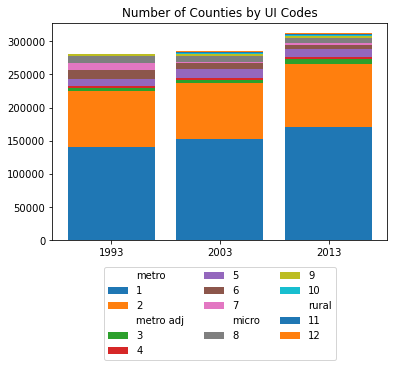

In [12]:
#| echo: true
#collapse
fig, ax = plt.subplots(figsize=(6, 4))
idx = [str(x) for x in data.index]
bottom = pd.Series([0] * len(data), index=data.index)
for code in data:
    ax.bar(idx, data[code], bottom=bottom, label=code)
    bottom += data[code]
    
dummy = mpl.patches.Patch(fill=False, edgecolor='none')
handles, labels = ax.get_legend_handles_labels()
handles = [dummy] + handles[:2] + [dummy] + handles[2:7] + [dummy] + handles[7:10] + [dummy] + handles[10:12]
labels = ['metro'] + labels[:2] + ['metro adj'] + labels[2:7] + ['micro'] + labels[7:10] + ['rural'] + labels[10:12]
ax.legend(handles, labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.1))

ax.set_title('Number of Counties by UI Codes')

fig_count = fig
plt.show()

### Population

In [10]:
#collapse
data = stats['Population']
data

UI_CODE,1,2,3,4,5,6,7,8,9,10,11,12
UI_YEAR,,,,,,,,,,,,
1993,140456,84861,4038,2867,10726,13823,10739,10365,3598,0,0,0
2003,151788,84464,5199,2364,14746,7886,1896,9139,3227,1313,2247,1010
2013,170874,95145,7261,3243,11239,7290,1592,8783,2798,1347,1959,934


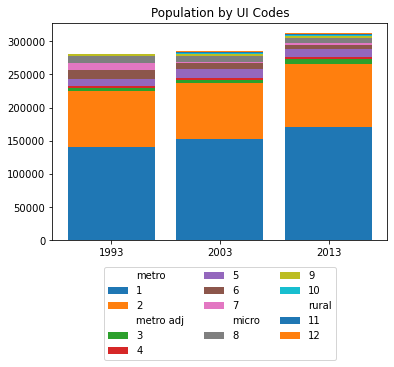

In [13]:
#collapse
fig, ax = plt.subplots(figsize=(6, 4))
idx = [str(x) for x in data.index]
bottom = pd.Series([0] * len(data), index=data.index)
for code in data:
    ax.bar(idx, data[code], bottom=bottom, label=code)
    bottom += data[code]
    
dummy = mpl.patches.Patch(fill=False, edgecolor='none')
handles, labels = ax.get_legend_handles_labels()
handles = [dummy] + handles[:2] + [dummy] + handles[2:7] + [dummy] + handles[7:10] + [dummy] + handles[10:12]
labels = ['metro'] + labels[:2] + ['metro adj'] + labels[2:7] + ['micro'] + labels[7:10] + ['rural'] + labels[10:12]
ax.legend(handles, labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.1))

ax.set_title('Population by UI Codes')
fig_pop = fig

plt.show()

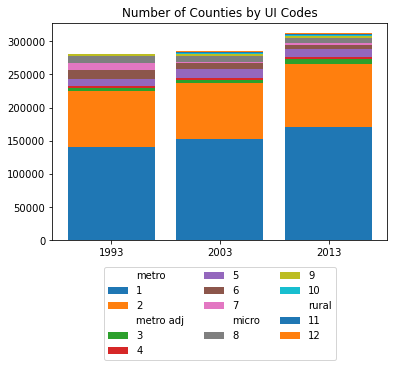

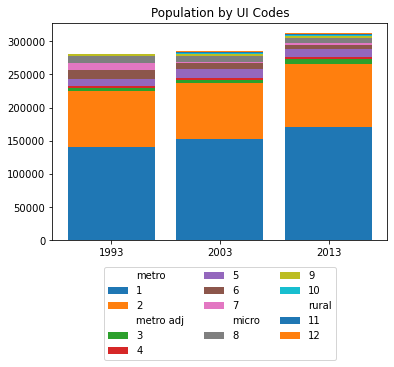

In [16]:
#| label: fig-ui-stats
#| fig-cap: UI change over time
#| fig-subcap:
#|   - "Number of counties"
#|   - "Population"
#| layout-ncol: 2
#| column: page
display(fig_count)
display(fig_pop)

## Map

Map below compares UI codes of Wisconsin counties in 2003 and 2013, using 2010 county boundaries.

Interesting example: Wasрburn county in the northwestern WI. It changed from "6" to "11", even though there is small metro county next to it (Douglas). It could still be reclassified. Why?

In [6]:
#| label: fig-polar
#| fig-cap: "A line plot on a polar axis"

df = get_ui_df().query('UI_YEAR == 2003 or UI_YEAR == 2013')
df['UI_CODE'] = df['UI_CODE'].astype(int)
df['UI_DESC'] = df['UI_CODE'].map({
    1: 'large metro',
    2: 'small metro',
    3: 'adj large: micro',
    4: 'adj large: noncore',
    5: 'adj small: micro',
    6: 'adj small: noncore w/ town',
    7: 'adj small: noncore no town',
    8: 'not adj: micro',
    9: 'adj micro: noncore w/ town',
    10: 'adj micro: no town',
    11: 'not adj: noncore w/ town',
    12: 'not adj: noncore no town'
})
df['NAME'] = df['COUNTY'] + ', ' + df['STATE']
df = df.rename(columns={'FIPS': 'FIPS_CODE'})
d = df

df = geography.get_county_df(2010)[['CODE', 'geometry']].rename(columns={'CODE': 'FIPS_CODE'})
df = df.merge(d)

d = df.query('STATE == "WI"')[['geometry', 'FIPS_CODE', 'NAME', 'UI_YEAR', 'UI_CODE', 'UI_DESC']]
m = d.query('UI_YEAR == 2013').drop(columns='UI_YEAR')\
    .merge(d.query('UI_YEAR == 2003')[['FIPS_CODE', 'UI_CODE', 'UI_DESC']], on='FIPS_CODE', suffixes=('_2013', '_2003'))\
    .explore(column='UI_CODE_2013', tiles='CartoDB positron', name=2013)
tile_layer = next(iter(m._children.values()))
tile_layer.control = False
d.query('UI_YEAR == 2003').drop(columns='UI_YEAR')\
    .merge(d.query('UI_YEAR == 2013')[['FIPS_CODE', 'UI_CODE', 'UI_DESC']], on='FIPS_CODE', suffixes=('_2003', '_2013'))\
    .explore(m=m, column='UI_CODE_2003', tiles='CartoDB positron', name=2003)
folium.LayerControl(collapsed=False).add_to(m)
m

File "/Users/anton/work/rurec/data/geo/source/county/2010_20m.zip" not found, attempting download.
Downloaded file 2010_20m.zip.


# Rural-Urban Commuting Area

[Homepage](https://www.ers.usda.gov/data-products/rural-urban-commuting-area-codes/)

In [ ]:
def get_ruca_df():
    """Return `pandas.DataFrame` of Rural-Urban Commuting Area codes for all years."""
    if not PATH.ruca.exists():
        print(f'RUCA data not found at "{PATH.ruca}", attempting to download and construct...')
        download_and_combine_ruca()
    df = pd.read_csv(PATH.ruca, dtype='str')
    for c in ['YEAR', 'POPULATION', 'AREA']:
        # ValueError: Unable to parse string "6 23.063" at position 269
        # todo: input files probably had this error, add manual fix to `download_and_convert_ruca()`
        df[c] = pd.to_numeric(df[c], 'coerce')
    cats = ['1', '1.1', 
            '2', '2.1', '2.2', 
            '3', 
            '4', '4.1', '4.2', 
            '5', '5.1', '5.2', 
            '6', '6.1', 
            '7', '7.1', '7.2', '7.3', '7.4', 
            '8', '8.1', '8.2', '8.3', '8.4', 
            '9', '9.1', '9.2', 
            '10', '10.1', '10.2', '10.3', '10.4', '10.5', '10.6', 
            '99']
    df['RUCA_CODE'] = df['RUCA_CODE'].str.replace('.0', '', regex=False)
    df['RUCA_CODE'] = pd.Categorical(df['RUCA_CODE'], cats, True)
    return df

def download_and_combine_ruca():
    """Download Rural-Urban Commuting Area codes and documentation.
    Combine all years of data into single CSV file.
    Save all documentation into single TXT file."""
    PATH.ruca.parent.mkdir(parents=True, exist_ok=True)
    ruca_orig = PATH.ruca.parent/'ruca_orig'
    ruca_dfs = []
    ruca_doc_dfs = []

    # 1990
    url = 'https://www.ers.usda.gov/webdocs/DataFiles/53241/ruca1990.xls?v=9882.5'
    fname = download_file(url, ruca_orig)

    df = pd.read_excel(fname, 'Data', dtype='str')
    cols_map = {'FIPS state-county-tract code': 'FIPS',
                'Rural-urban commuting area code': 'RUCA_CODE',
                'Census tract population, 1990': 'POPULATION',
                'Census tract land area, square miles, 1990': 'AREA',
                'County metropolitan status, 1993 (1=metro,0=nonmetro)': 'METRO'}
    df = df.rename(columns=cols_map)
    df = df[cols_map.values()]
    df['FIPS'] = df['FIPS'].str.replace('.', '', regex=False)
    df['YEAR'] = '1990'
    ruca_dfs.append(df)

    df = pd.concat([
        pd.DataFrame(['RUCA 1990 documentation', '-' * 80, f'Data source: {url}']),
        pd.DataFrame([[''], ['Column names'], ['Renamed', 'Original']]),
        pd.DataFrame([[v, k] for k, v in cols_map.items()]),
        pd.DataFrame(['']),
        pd.read_excel(fname, 'RUCA code description', header=None, dtype='str'),
        pd.DataFrame(['', 'Data sources']),
        pd.read_excel(fname, 'Data sources', header=None, dtype='str')])
    ruca_doc_dfs.append(df)


    # 2000
    url = 'https://www.ers.usda.gov/webdocs/DataFiles/53241/ruca00.xls?v=9882.5'
    fname = download_file(url, ruca_orig)

    df = pd.read_excel(fname, 'Data', dtype='str')

    cols_map = {
        'Select State': 'STATE',
        'Select County ': 'COUNTY',
        'State County Tract Code': 'FIPS',
        'RUCA Secondary Code 2000': 'RUCA_CODE',
        'Tract Population 2000': 'POPULATION'
    }
    df = df.rename(columns=cols_map)
    df = df[cols_map.values()]
    df['YEAR'] = '2000'
    ruca_dfs.append(df)

    df = pd.concat([
        pd.DataFrame(['RUCA 2000 documentation', '-' * 80, f'Data source: {url}']),
        pd.DataFrame([[''], ['Column names'], ['Renamed', 'Original']]),
        pd.DataFrame([[v, k] for k, v in cols_map.items()]),
        pd.DataFrame(['']),
        pd.read_excel(fname, 'RUCA code description', header=None, dtype='str'),
        pd.DataFrame(['', 'Data sources']),
        pd.read_excel(fname, 'Data sources', header=None, dtype='str')])
    ruca_doc_dfs.extend([pd.DataFrame(['', '']), df])


    # 2010
    url = 'https://www.ers.usda.gov/webdocs/DataFiles/53241/ruca2010revised.xlsx?v=9882.5'
    fname = download_file(url, ruca_orig)

    df = pd.read_excel(fname, 'Data', dtype='str', skiprows=1)
    cols_map = {
        'Select State': 'STATE',
        'Select County': 'COUNTY',
        'State-County-Tract FIPS Code (lookup by address at http://www.ffiec.gov/Geocode/)': 'FIPS',
        'Secondary RUCA Code, 2010 (see errata)': 'RUCA_CODE',
        'Tract Population, 2010': 'POPULATION',
        'Land Area (square miles), 2010': 'AREA'
    }
    df = df.rename(columns=cols_map)
    df = df[cols_map.values()]
    df['YEAR'] = '2010'
    ruca_dfs.append(df)

    df = pd.concat([
        pd.DataFrame(['RUCA 2010 documentation', '-' * 80, f'Data source: {url}']),
        pd.DataFrame([[''], ['Column names'], ['Renamed', 'Original']]),
        pd.DataFrame([[v, k] for k, v in cols_map.items()]),
        pd.DataFrame(['']),
        pd.read_excel(fname, 'RUCA code description', header=None, dtype='str'),
        pd.DataFrame(['', 'Data sources']),
        pd.read_excel(fname, 'Data sources', header=None, dtype='str')])
    ruca_doc_dfs.extend([pd.DataFrame(['', '']), df])


    # Combine and save to disk
    df = pd.concat(ruca_dfs)
    df = df[['FIPS', 'STATE', 'COUNTY', 'YEAR', 'RUCA_CODE', 'POPULATION', 'AREA', 'METRO']]
    for col in df:
        df[col] = df[col].str.strip()
    df = df.sort_values(['FIPS', 'YEAR'])
    df.to_csv(PATH.ruca, index=False)
    print(f'Saved combined data to "{PATH.ruca}".')

    df = pd.concat(ruca_doc_dfs)
    for col in df:
        df[col] = df[col].str.strip()
    df.to_csv(PATH.ruca_doc, '\t', header=False, index=False)
    print(f'Saved documentation to "{PATH.ruca_doc}".')

## Descriptive summary

# Tests

In [ ]:
df = get_ruc_df()
assert df.shape == (15864, 9)
assert df['RUC_CODE'].notna().all()

In [ ]:
df = get_ui_df()
assert df.shape == (9583, 9)
assert df['UI_CODE'].notna().all()

In [ ]:
df = get_ruca_df()
assert df.shape == (200581, 8)
assert df['RUCA_CODE'].notna().all()

# Build this module

In [ ]:
from rurec.reseng.nbd import Nbd
nbd = Nbd('rurec')
nbd.nb2mod('ers_codes.ipynb')